In [2]:
import sqlite3
from sqlite3 import Error
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotnine
from plotnine import *
from plotnine.animation import PlotnineAnimation

import sys
sys.path.append("../lib/")
from dblib import create_connection, execute_cmd

## Connect to database

In [9]:
db_file = "chargePoint.db"
conn = create_connection(db_file)
print("Connected to database")

Connected to database


## Unique Counts

In [10]:
sqlcmd = "SELECT COUNT(StationID) FROM station "
rows = execute_cmd(conn, sqlcmd)
print("Number of unique stations: ", rows[0][0])

('Number of unique stations: ', 11)


In [11]:
sqlcmd = "SELECT COUNT(userID) FROM user"
rows = execute_cmd(conn, sqlcmd)
print("Number of unique users: ", rows[0][0])

('Number of unique users: ', 976)


In [12]:
sqlcmd = "SELECT COUNT(sessionID) FROM session"
rows = execute_cmd(conn, sqlcmd)
print("Number of recorded sessions: ", rows[0][0])

('Number of recorded sessions: ', 14862)


In [13]:
sqlcmd = "SELECT startTime FROM session LIMIT 1"
rows = execute_cmd(conn, sqlcmd)
sDate = datetime.strptime(rows[0][0], "%Y-%m-%d %H:%M:%S")
sqlcmd = """SELECT startTime FROM session
            ORDER BY startTime DESC LIMIT 1
         """
rows = execute_cmd(conn, sqlcmd)
eDate = datetime.strptime(rows[0][0], "%Y-%m-%d %H:%M:%S")
print("Start date of recorded sessions: ", datetime.strftime(sDate, '%d-%b-%Y %A'))
print("End date of recorded sessions: ", datetime.strftime(eDate, '%d-%b-%Y %A'))

('Start date of recorded sessions: ', '04-Jan-2014 Saturday')
('End date of recorded sessions: ', '05-Jul-2018 Thursday')


In [14]:
## Get all session records and save as a dataframe
sqlcmd = "SELECT * FROM session"
rows = execute_cmd(conn, sqlcmd)
df_session = pd.DataFrame.from_records(rows, columns=['sessionID', 'startTime', 'endTime', 'Energy', 'stationID',
                                                     'userID', 'credentialID', 'portNumber'])
## Make time columns datetime format
df_session['startTime'] = df_session['startTime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df_session['endTime'] = df_session['endTime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

## Make new columns called Year, Month, WeekDay and Hour
# yearCol = list(df_session['startTime'])
# yearCol = [x.year for x in yearCol]
df_session['Year']  = df_session['startTime'].apply(lambda x: x.year)
df_session['Month'] = df_session['startTime'].apply(lambda x: x.month)
df_session['WeekDay']   = df_session['startTime'].apply(lambda x: x.weekday()) 
df_session['Hour']  = df_session['startTime'].apply(lambda x: x.hour)

## Make new column called Length
df_session['Length'] = df_session['endTime'] - df_session['startTime']
# df_session.head(10)

## Clean Data: Remove entries where Energy <= 0  and Length <= 0

In [15]:
idxKeep = df_session['Energy'] > 0
print(len(df_session))
df_session = df_session[idxKeep]
print(len(df_session))
# df_session.head()

14862
14519


In [16]:
idxKeep = df_session['Length'] > timedelta(seconds=0)
print(len(df_session))
df_session = df_session[idxKeep]
print(len(df_session))
# df_session.head()

14519
14512


## Study Usage Patterns for >= 4 hours charging

In [17]:
idx = df_session['Length'] >= timedelta(hours=4)

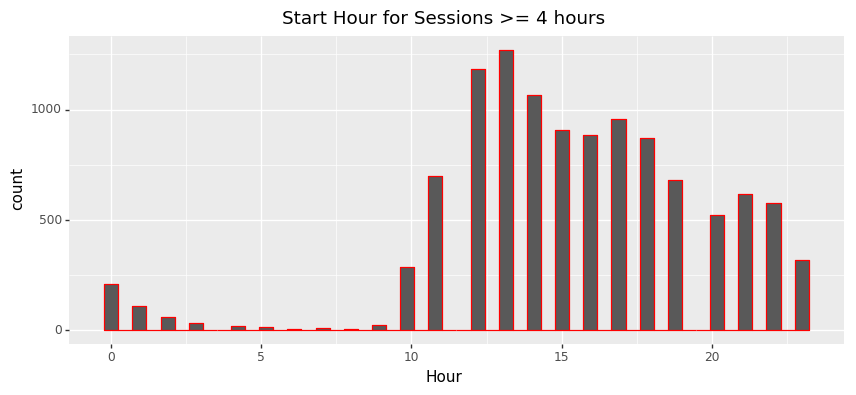

<ggplot: (7541876633)>

In [46]:
plotnine.options.figure_size = (10, 4)
ggplot(df_session[idx], aes('Hour')) + geom_histogram(bins=50, color='r') +\
    labs(title="Start Hour for Sessions >= 4 hours")

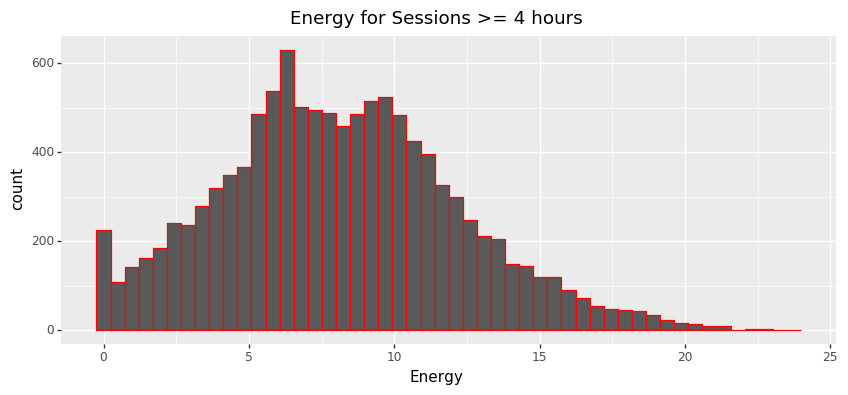

<ggplot: (7541005933)>

In [45]:
plotnine.options.figure_size = (10, 4)
ggplot(df_session[idx], aes('Energy')) + geom_histogram(bins=50, color='r') +\
    labs(title="Energy for Sessions >= 4 hours")

## Study Usage Patterns < 4 hours

In [40]:
idx = df_session['Length'] < timedelta(hours=4)

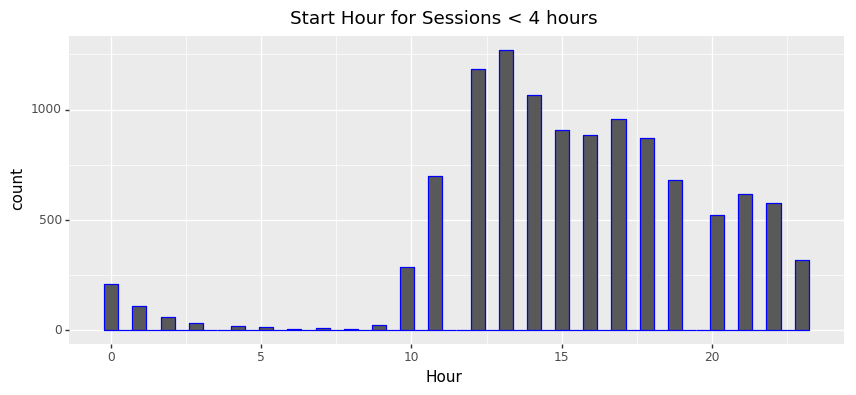

<ggplot: (7540625841)>

In [41]:
ggplot(df_session[idx], aes('Hour')) + geom_histogram(bins=50, color='b') +\
    labs(title="Start Hour for Sessions < 4 hours")

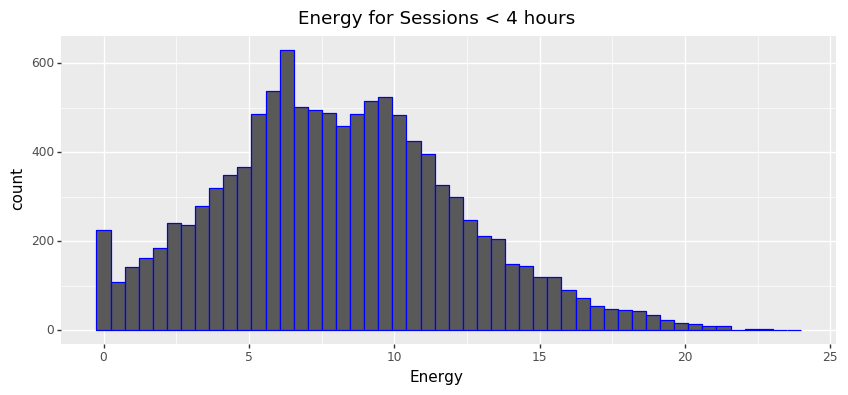

<ggplot: (7540586913)>

In [42]:
ggplot(df_session[idx], aes('Energy')) + geom_histogram(bins=50, color='b') +\
    labs(title="Energy for Sessions < 4 hours")

## Overall Trends

/usr/local/lib/python2.7/site-packages/plotnine/positions/position.py:194: UserWarning:

position_stack requires non-overlapping x intervals



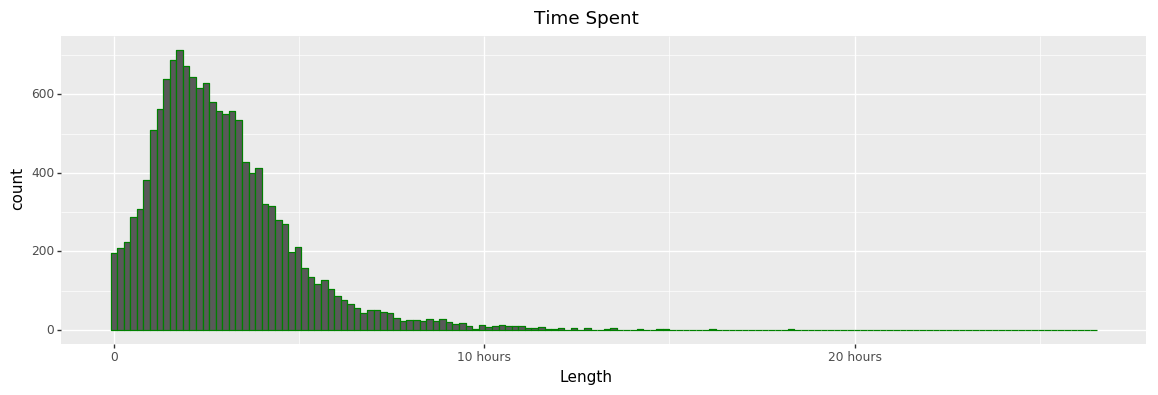

<ggplot: (7542298945)>

In [50]:
plotnine.options.figure_size = (14, 4)
ggplot(df_session, aes('Length')) + geom_histogram(bins=150, color='g') +\
    labs(title="Time Spent")

/usr/local/lib/python2.7/site-packages/plotnine/stats/stat_bin.py:90: UserWarning:

'stat_bin()' using 'bins = 56'. Pick better value with 'binwidth'.

/usr/local/lib/python2.7/site-packages/plotnine/positions/position.py:194: UserWarning:

position_stack requires non-overlapping x intervals



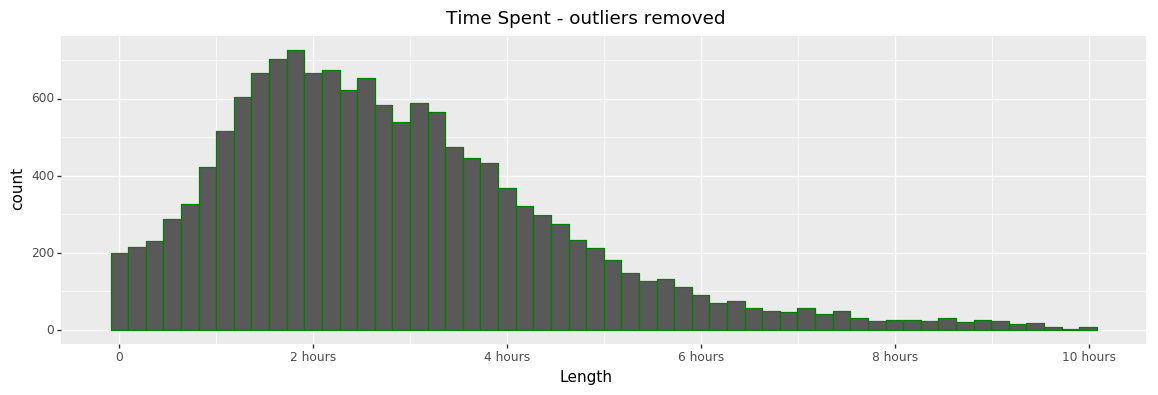

<ggplot: (7540794433)>

In [19]:
## Remove the outliers (> 10 hours)
plotnine.options.figure_size = (14, 4)
idx = df_session['Length'] < timedelta(hours=10)
ggplot(df_session[idx], aes('Length')) + geom_histogram(color='g') + labs(title="Time Spent - outliers removed")

## Does the amount of energy used correlate with time spent at station?
- Mostly linear

- Can see trends for different stations (plot individually)

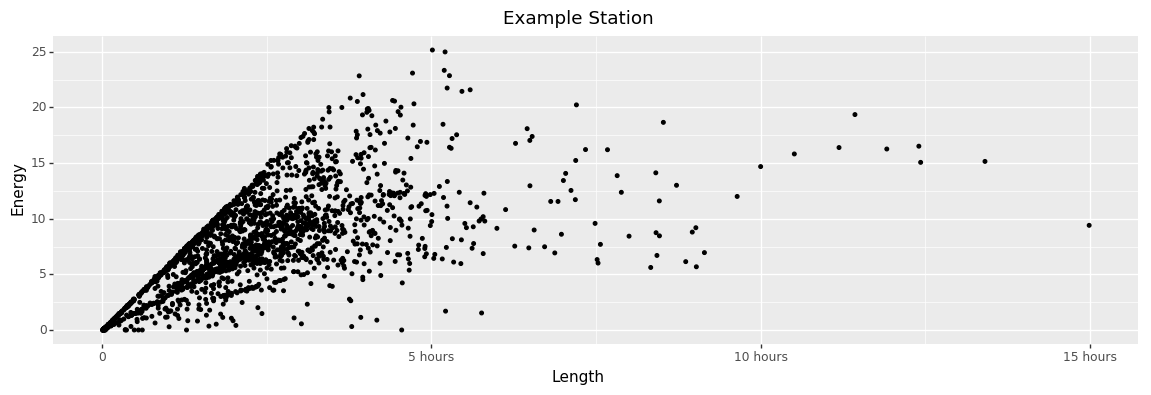

<ggplot: (7550221581)>

In [20]:
title = "Example Station"
ggplot(df_session[idx], aes(x='Length', y='Energy')) + geom_point(size=1) + labs(title=title)

## Power vs Time

Power-Time curve: shows that charging occurs at a constant rate of 6.6kWh (for the ChargePoint port case), and then tapers off. We can approximate the time to charge as TimeToCharge (hrs) =  Energy / 6.6.

Then, we can study how long users stay after their vehicle is charged as TimeAfterCharge (hrs) = Length - TimeToCharge.

This is of course a rough approximation, since we don't factor in the nonlinearity at the end of the charge

In [21]:
df_session['TimeToCharge'] = df_session['Energy'] / 6.6
df_session['TimeAfterCharged'] = df_session['Length'].apply(lambda x: timedelta.total_seconds(x)/3600.0) - df_session['TimeToCharge']
df_session['Power'] = df_session['Energy'] / df_session['Length'].apply(lambda x: timedelta.total_seconds(x))
# df_session.head()

### What is the typical SoC of vehicles?
Approximate using TimeToCharge vehicle

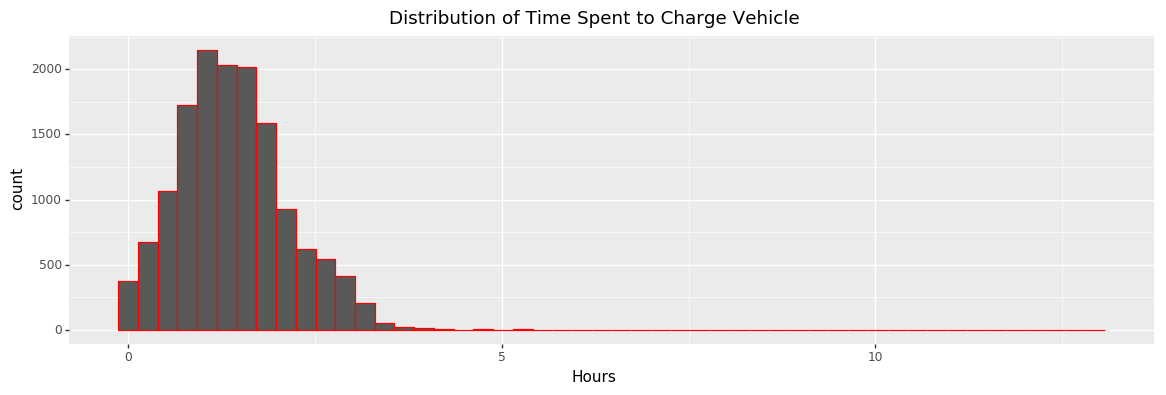

<ggplot: (7540873553)>

In [73]:
ggplot(df_session, aes('TimeToCharge')) + geom_histogram(bins=50, color='r') +\
    labs(title="Distribution of Time Spent to Charge Vehicle", x="Hours")

We can see that most users spend about 2 hours charging

### For reference, here's the amount of time spent at the charging station

/usr/local/lib/python2.7/site-packages/plotnine/positions/position.py:194: UserWarning:

position_stack requires non-overlapping x intervals



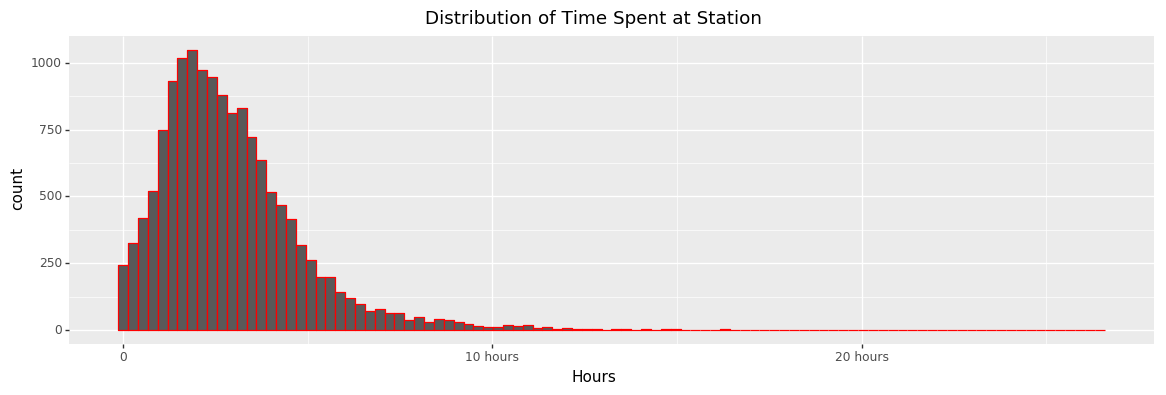

<ggplot: (7542466321)>

In [75]:
ggplot(df_session, aes('Length')) + geom_histogram(bins=100, color='r') +\
    labs(title="Distribution of Time Spent at Station", x="Hours")

## Any trends for Time Spent by Month, Year, Weekday, Hour?

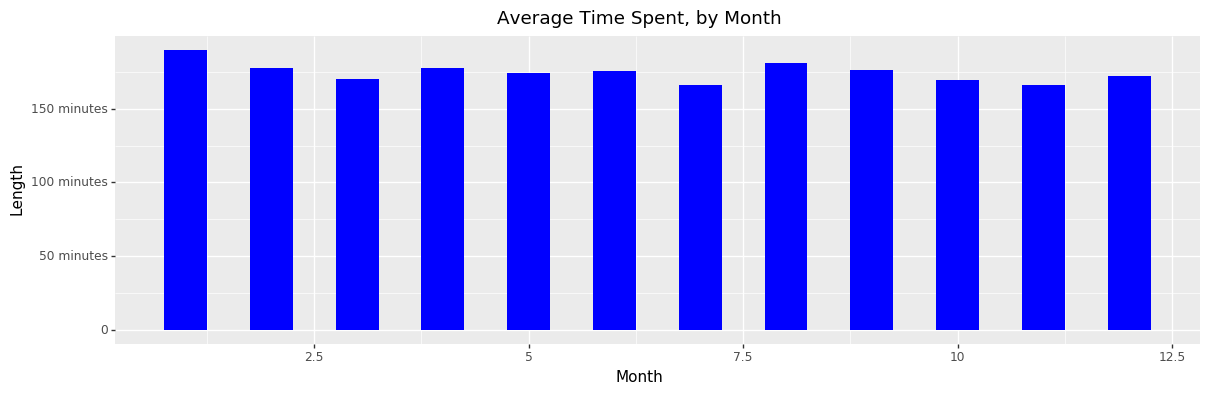

<ggplot: (7544126117)>

In [79]:
ggplot(df_session, aes(x='Month', y='Length')
      ) + geom_bar(stat="summary", fun_y=np.mean, width=.5, fill='blue'
      ) + labs(title="Average Time Spent, by Month")

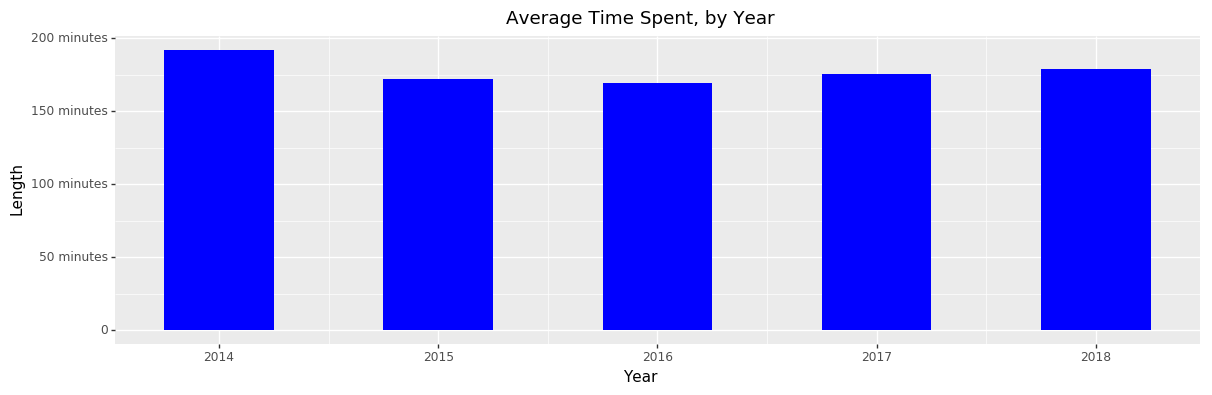

<ggplot: (7542100221)>

In [80]:
ggplot(df_session, aes(x='Year', y='Length')
      ) + geom_bar(stat="summary", fun_y=np.mean, width=.5, fill='blue'
      ) + labs(title="Average Time Spent, by Year")

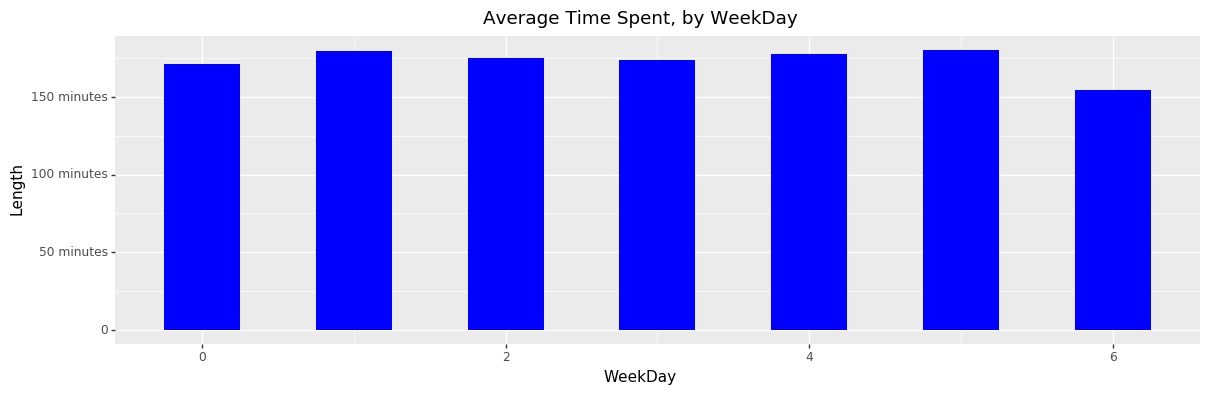

<ggplot: (7540985293)>

In [81]:
ggplot(df_session, aes(x='WeekDay', y='Length')
      ) + geom_bar(stat="summary", fun_y=np.mean, width=.5, fill='blue'
      ) + labs(title="Average Time Spent, by WeekDay")

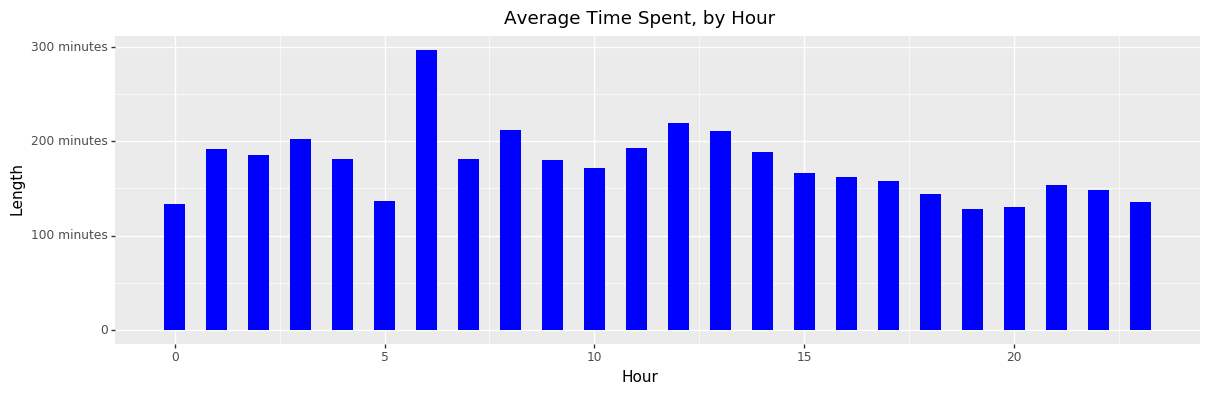

<ggplot: (7543855649)>

In [82]:
ggplot(df_session, aes(x='Hour', y='Length')
      ) + geom_bar(stat="summary", fun_y=np.mean, width=.5, fill='blue'
      ) + labs(title="Average Time Spent, by Hour")

## Energy Daily Usage

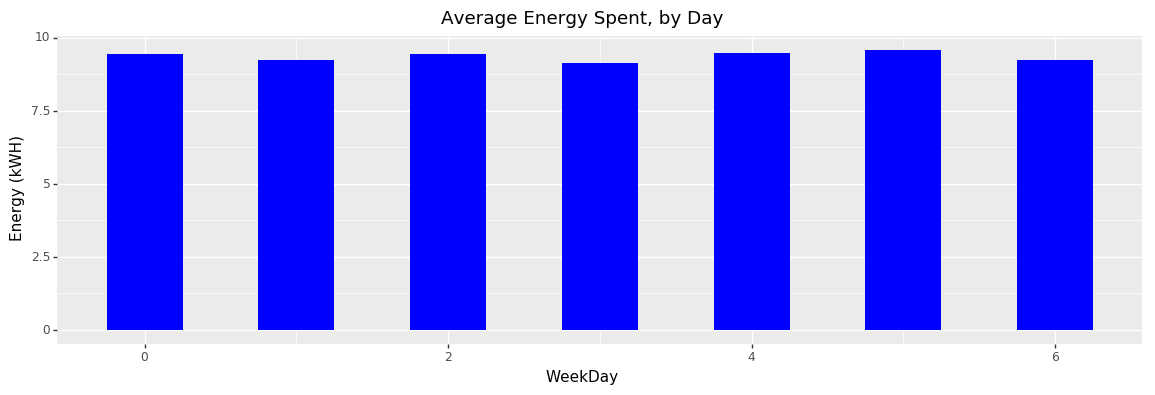

<ggplot: (7542280269)>

In [87]:
ggplot(df_session, aes(x='WeekDay', y='Energy')
      ) + geom_bar(stat="summary", fun_y=np.mean, width=.5, fill='blue'
      ) + labs(title="Average Energy Spent, by Day", y="Energy (kWH)")